In [4]:
from fastai.collab import *
from fastai.tabular import *

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [6]:
import torch

In [7]:
# Read number of user
reactions = pd.read_csv("../data/raw/lhpconfessions_facebook_reactions.csv")
reactions = reactions.loc[:, ["status_id", "author_id", "reaction_status"]]
reactions.head()
print("number of reactions %d" % len(reactions))

number of reactions 440563


In [8]:
n_users = reactions["author_id"].unique()
print("number of users %d" % len(n_users))
n_items = reactions["status_id"].unique()
print("number of items %d" % len(n_items))

number of users 34256
number of items 2614


In [9]:
# Matching the rating
react_symbol = reactions["reaction_status"].unique()
number_symbol = list(range(0, len(react_symbol)))
reactions["reaction_status"] = reactions["reaction_status"] \
        .map(dict(zip(react_symbol, number_symbol)))
reactions.head()

,status_id,author_id,reaction_status
0,465230273544818_1292740664127104,1264309156990382,0
1,465230273544818_1292740664127104,1848910212031498,1
2,465230273544818_1292740664127104,1370248489699803,0
3,465230273544818_1292740664127104,587988901393696,2
4,465230273544818_1292740664127104,637210566475078,0


In [83]:
doc(CollabDataBunch)

class CollabDataBunch [source] [test] CollabDataBunch ( train_dl : DataLoader , valid_dl : DataLoader , fix_dl : DataLoader = None , test_dl : Optional [ DataLoader ]= None , device : device = None , dl_tfms : Optional [ Collection [ Callable ]]= None , path : PathOrStr = '.' , collate_fn : Callable = 'data_collate' , no_check : bool = False ) :: DataBunch 
 
 × No tests found for CollabDataBunch . To contribute a test please refer to this guide and this discussion . Base DataBunch for collaborative filtering. 
 Show in docs

In [10]:
y_range = range(0,5)

## Split the train and valid index
train_idx, valid_idx = np.split(reactions.index, [int(0.8 * len(reactions))])

data = (CollabDataBunch.from_df(reactions, valid_pct = 0, user_name = "author_id", item_name = "status_id", rating_name = "reaction_status")
        .split_by_idx(valid_idx.values)
        .label_from_df(cols="reaction_status")
        .databunch())

# data = CollabDataBunch.from_df(reactions, valid_pct = .2, user_name = "author_id", item_name = "status_id", rating_name = "reaction_status")
data

TabularDataBunch;

Train: LabelList (352450 items)
x: CollabList
author_id 1264309156990382; status_id 465230273544818_1292740664127104; ,author_id 1848910212031498; status_id 465230273544818_1292740664127104; ,author_id 1370248489699803; status_id 465230273544818_1292740664127104; ,author_id 587988901393696; status_id 465230273544818_1292740664127104; ,author_id 637210566475078; status_id 465230273544818_1292740664127104; 
y: FloatList
0.0,1.0,0.0,2.0,0.0
Path: .;

Valid: LabelList (88113 items)
x: CollabList
author_id 1485681458117846; status_id 465230273544818_658276737573503; ,author_id 1377012665704661; status_id 465230273544818_658276737573503; ,author_id 798301500325844; status_id 465230273544818_658276737573503; ,author_id 1059403920830239; status_id 465230273544818_658276737573503; ,author_id 777823325720273; status_id 465230273544818_658276737573503; 
y: FloatList
0.0,0.0,0.0,0.0,0.0
Path: .;

Test: None

In [11]:
learn = collab_learner(data, n_factors=5, y_range=y_range, callback_fns = ShowGraph)

# Matrix factorize

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


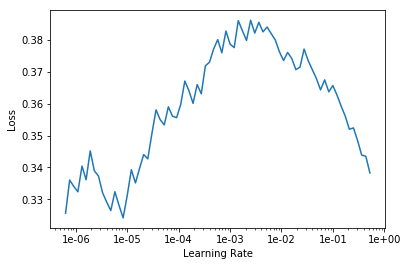

In [38]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

epoch,train_loss,valid_loss,time
0,0.402806,0.249988,00:52


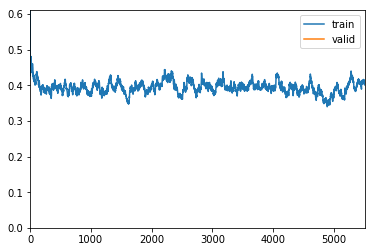

In [39]:
learn.fit_one_cycle(1, max_lr=1e-06 * 2)

In [40]:
learn.save("mf")

### Interperate the model

In [109]:
learn.load("mf")
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(2614, 5)
  (i_weight): Embedding(32628, 5)
  (u_bias): Embedding(2614, 1)
  (i_bias): Embedding(32628, 1)
)

In [110]:
learn.validate(learn.data.valid_dl)

[0.35816142]

In [160]:
# Predict the given user and item
author_id = "1848910212031498"
status_id = "465230273544818_1292740664127104"
author_weight = learn.weight([author_id], is_item = False)
status_weight = learn.weight([status_id], is_item = True)

series = reactions[(reactions["author_id"] == int(author_id)) & (reactions["status_id"] == status_id)]
print(torch.dot(author_weight[0], status_weight[0]) + learn.bias([author_id], is_item = False) + learn.bias([status_id], is_item = True))

tensor(0.0063)


# Embedding with neural model

In [ ]:
neural_learner = collab_learner(data, use_nn = True, emb_szs = {"author_id": 5, "status_id": 5}, layers=[5], \
                               y_range=y_range)
neural_learner

In [ ]:
neural_learner.lr_find()
neural_learner.recorder.plot()

In [ ]:
neural_learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,time


# Interperate models

### Create the normal distribution error

In [ ]:
def normal_distribution_loss(data, learn):
    '''
      Assume the data is DataFrame - author_id, status_id, reaction_status  
    '''
    author_weight = learn.weight(data["author_id"].astype(str).values, is_item = False)
    status_weight = learn.weight(data["status_id"].astype(str).values, is_item = True)
    author_bias = learn.bias(data["author_id"].astype(str).values, is_item = False)
    status_bias = learn.bias(data["status_id"].astype(str).values, is_item = True)
    pred = torch.mul(status_weight, author_weight)
    pred = torch.sum(pred, dim=1)
    pred = pred + author_bias + status_bias
    mse = (data["reaction_status"] - pred) ** 2
    print(mse)
    
learn.load("mf")
normal_distribution_loss(reactions.loc[train_idx], learn)

tensor([[-0.0002,  0.0045,  0.0037,  0.0008,  0.0046],
        [-0.0087, -0.0005,  0.0082,  0.0020,  0.0120],
        [-0.0008,  0.0133, -0.0100,  0.0050,  0.0069],
        ...,
        [-0.0172, -0.0069,  0.0014, -0.0092,  0.0054],
        [ 0.0082,  0.0081, -0.0010,  0.0007,  0.0088],
        [-0.0171,  0.0081, -0.0093, -0.0196, -0.0064]])


NameError: name 'author' is not defined